In [1]:
import datetime

print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")


Notebook last run (end-to-end): 2024-09-09 17:35:28.347010


In [2]:
import numpy as np
import pandas as pd


In [3]:
import tensorflow as tf
from tensorflow import keras

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        print(e)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('tf version : ', tf.__version__)


Num GPUs Available:  1
tf version :  2.10.0


## End-to-end Inception Network
![](img.png)


## Layers

### Conv Module


In [4]:
class ConvModule(keras.layers.Layer):
    def __init__(self,
                 num_filters, kernel_size, strides, padding='same'):
        super().__init__()
        # Conv layer
        self.conv = keras.layers.Conv2D(filters=num_filters,
                                        kernel_size=kernel_size,
                                        strides=strides,
                                        padding=padding)
        # BatchNorm layer
        self.bn = keras.layers.BatchNormalization()

    def call(self, _inputs, training=False):
        x = self.conv(_inputs)  # Convolutional operation without activation
        x = self.bn(x)
        x = tf.nn.relu(x)  # ReLU activation applied after batch normalization

        return x

In [5]:
cm = ConvModule(16, (3, 3), (1, 1))
y = cm(tf.ones(shape=(4, 28, 28, 3)))  # first call to the `cm` will create weights

In [6]:
print(f'weights : {len(cm.weights)}')
print(f'trainable weights : {len(cm.trainable_weights)}')  # Kernel weights, biases, beta & gamma of BN
print(f'non trainable weights : {len(cm.non_trainable_weights)}')  # Moving mean and variance calculated in forward pass


weights : 6
trainable weights : 4
non trainable weights : 2


### Inception Module
- Padding have already been set to 'same' in the convmodule so that the dimensions of the feature maps will be the same for both (self.con1 , self.conv2).

- num of filters should be dynamic as we can see in the scheme, it variates.

- By concatenating the channels, the network can learn different types of features from the input tensor, such as local and global features, and combine them into a richer representation for further processing in the subsequent layers.

In [7]:
class InceptionModule(keras.layers.Layer):
    def __init__(self, num_filters1, num_filters2):
        super().__init__()
        self.conv1 = ConvModule(
            num_filters1,
            kernel_size=(1, 1),
            strides=(1, 1)
        )

        self.conv2 = ConvModule(
            num_filters2,
            kernel_size=(3, 3),
            strides=(1, 1)
        )

        self.cat = keras.layers.Concatenate()

    def call(self, _inputs, training=False):
        x1 = self.conv1(_inputs)
        x2 = self.conv2(_inputs)
        x = self.cat([x1, x2])  # concat channels/feature maps 

        return x

In [8]:
incp = InceptionModule(16, 10)
y = incp(tf.ones(shape=(4, 28, 28, 3)))  # first call to the `cm` will create weights

In [9]:
y.shape  # (batch_size, width, height, channels concatenated) 

TensorShape([4, 28, 28, 26])

## Downsample Module

In [10]:
class DownsampleModule(keras.layers.Layer):
    def __init__(self, num_filters):
        super().__init__()

        self.conv = ConvModule(num_filters,
                               kernel_size=(3, 3),
                               strides=(2, 2),
                               padding='valid'
                               )
        self.mp = keras.layers.MaxPooling2D(
            pool_size=(3, 3),
            strides=(2, 2),
            padding='valid'

        )
        self.cat = keras.layers.Concatenate()

    def call(self, _inputs):
        # forward pass
        conv_x = self.conv(_inputs)
        pool_x = self.mp(_inputs)
        x = self.cat([conv_x, pool_x])  # merge

        return x


## Model class: Layer Encomapassing
The model class will encompass the layers/modules we defined previously to create a network

In [11]:
class InceptionModel(keras.Model):
    def __init__(self, nb_classes=10):
        super().__init__()

        # First Block
        self.conv_1 = ConvModule(96, (3, 3), (1, 1))

        # Second Block
        self.incep_2_1 = InceptionModule(32, 32)
        self.incep_2_2 = InceptionModule(32, 48)
        self.downsample_2 = DownsampleModule(80)

        # Third Block 
        self.incep_3_1 = InceptionModule(112, 48)
        self.incep_3_2 = InceptionModule(96, 64)
        self.incep_3_3 = InceptionModule(80, 80)
        self.incep_3_4 = InceptionModule(48, 96)
        self.downsample_3 = DownsampleModule(96)

        # Fourth Block
        self.incep_4_1 = InceptionModule(176, 160)
        self.incep_4_2 = InceptionModule(176, 160)
        self.avg_pool_4 = keras.layers.AveragePooling2D((7, 7))

        self.flat_4 = keras.layers.Flatten()
        self.dense_4 = keras.layers.Dense(
            nb_classes,
            activation='softmax')

    def call(self, _inputs, training=False, **kwargs):
        # forward pass
        x = self.conv_1(_inputs)

        x = self.incep_2_1(x)
        x = self.incep_2_2(x)
        x = self.downsample_2(x)

        x = self.incep_3_1(x)
        x = self.incep_3_2(x)
        x = self.incep_3_3(x)
        x = self.incep_3_4(x)
        x = self.downsample_3(x)

        x = self.incep_4_1(x)
        x = self.incep_4_2(x)
        x = self.avg_pool_4(x)

        x = self.flat_4(x)
        return self.dense_4(x)

    def build_graph(self, raw_shape):
        x = keras.Input(shape=raw_shape)
        return keras.Model(inputs=[x], outputs=self.call(x))


In [12]:
raw_input = (32, 32, 3)

# init model object
cm = InceptionModel()

# The first call to the `cm` will create the weights
y = cm(tf.ones(shape=(0, *raw_input)))

# print summary
cm.build_graph(raw_input).summary()
# tf.keras.utils.plot_model(
#     cm.build_graph(raw_input),                      # here is the trick (for now)
#     to_file='model.png', dpi=96,              # saving  
#     show_shapes=True, show_layer_names=True,  # show shapes and layer name
#     expand_nested=False                       # will show nested block
# )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv_module_3 (ConvModule)  (None, 32, 32, 96)        3072      
                                                                 
 inception_module_1 (Incepti  (None, 32, 32, 64)       31040     
 onModule)                                                       
                                                                 
 inception_module_2 (Incepti  (None, 32, 32, 80)       30096     
 onModule)                                                       
                                                                 
 downsample_module (Downsamp  (None, 15, 15, 160)      58000     
 leModule)                                                       
                                                             

This line is a bit tricky and serves a specific purpose. Let's break it down further:

`tf.ones(shape=(0,*raw_input))` :

- This creates a tensor of ones with shape (0, 32, 32, 3).
- The `*raw_input` unpacks the raw_input tuple.
- The leading 0 in the shape means it's creating an empty batch.

The reason for using an empty batch (shape starting with 0) is to initialize the model's weights without actually performing any computation. This is a technique sometimes used to inspect or manipulate a model's architecture before training.

Now, the model is complete we need to train it


## End-to-End Training with Custom Training Loop from Scratch

We can train now this model using **compile & fit**, but we will look at custom training loop from scratch introduces in Tensorflow 2


### Data set 
**CIFAR-10** gonna be used for the demonstration

In [13]:
BATCH_SIZE = 256

In [14]:
(x_train, y_train), (x_holdout, y_holdout) = keras.datasets.cifar10.load_data()
print(x_train.shape, y_train.shape)
print(x_holdout.shape, y_holdout.shape)



(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [15]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_holdout, y_holdout, test_size=0.4)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(4000, 32, 32, 3) (4000, 1)
(6000, 32, 32, 3) (6000, 1)


In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [17]:
def preprocess_dataset(x, y):
    x = tf.cast(x, tf.float32) / 255 # Normalize data
    y = tf.one_hot(tf.squeeze(y), depth=10) # We added tf.squeeze(y) to remove the extra dimension from the labels, as tf.one_hot expects a 1D tensor.
    
    return x , y

In [18]:
train_dataset = train_dataset.map(preprocess_dataset).shuffle(1024).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(preprocess_dataset).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(preprocess_dataset).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [19]:
x_train = x_train.astype('float32') / 255  # Normalize data
x_test = x_test.astype('float32') / 255
x_val = x_val.astype('float32') / 255

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

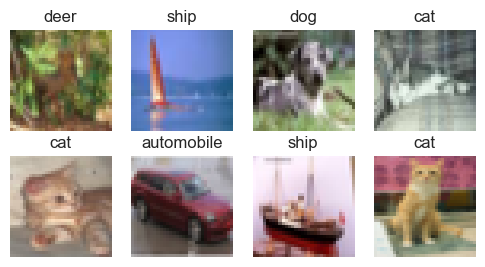

In [20]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(6, 3))
for i in range(8):  # Visualize chunk of the dataset
    rand_nb = random.randint(0, len(x_train) - 1)
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_train[rand_nb], cmap=plt.cm.binary)
    plt.title(class_names[y_train[rand_nb][0]])
    plt.axis('off')


Convert labels **(y_train, y_test)** to multi-class matrix

In [21]:
for dataset in ([train_dataset, val_dataset, test_dataset]):
    for i, (x,y) in enumerate(dataset):
        print(x.shape, y.shape) #  batch size , width x height image, channels(RGB)
        if i == 1:
            print('------------------------')
            break

(256, 32, 32, 3) (256, 10)
(256, 32, 32, 3) (256, 10)
------------------------
(256, 32, 32, 3) (256, 10)
(256, 32, 32, 3) (256, 10)
------------------------
(256, 32, 32, 3) (256, 10)
(256, 32, 32, 3) (256, 10)
------------------------


### Training Mechanism

#### Low level control of training loop:
1.  We open a for loop that will iterate over the number of epochs.
2. For each epoch, we open another for loop that will iterate over the datasets, in batches (x, y).
3. For each batch, we open GradientTape() scope.
4. Inside this scope, we call the model, the forward pass, and compute the loss.
5. Outside this scope, we retrieve the gradients of the weights of the model with regard to the loss.
6. Next, we use the optimizer to update the weights of the model based on the gradients.

TensorFlow provides the `tf.GradientTape()` API for automatic differentiation, that is, computing the gradient of computation with respect to some inputs.


In [22]:
# x:input, w,b: trainable param - x*w + b
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.], [1., 2., 3.]]


# Open a GradientTape to record the operations run
# during the forward pass, which enables auto-differentiation.

with tf.GradientTape(persistent=True) as tape:
    y = x @ w + b # output from the forward pass (for the actual model)
    
    # Compute the loss value for this minibatch.
    loss = tf.reduce_mean(y**2)


# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, [w, b])
print(grad)



[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.07866383,  2.6718152 ],
       [-0.15732765,  5.3436303 ],
       [-0.23599148,  8.015446  ]], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.07866383,  2.6718152 ], dtype=float32)>]


In [23]:
# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.Adam()

# Instantiate a loss function
loss_fn = keras.losses.CategoricalCrossentropy()

# Prepare the metrics.
train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric   = keras.metrics.CategoricalAccuracy()

# tensorboard writer 
train_writer = tf.summary.create_file_writer('logs/train/')
test_writer  = tf.summary.create_file_writer('logs/test/')

model = InceptionModel()
@tf.function
def train_step(step, x, y):
    # start the scope of gradient 
    
    with tf.GradientTape() as tape:
        logits = model(x, training=True) # forward pass
        train_loss_value = loss_fn(y, logits) # compute loss 

    # compute gradient 
    grads = tape.gradient(train_loss_value, model.trainable_weights)

    # update weights
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # update metrics
    train_acc_metric.update_state(y, logits)
    
    # write training loss and accuracy to the tensorboard
    with train_writer.as_default():
        tf.summary.scalar('loss', train_loss_value, step=step)
        tf.summary.scalar('accuracy', train_acc_metric.result(), step=step)
    return train_loss_value

@tf.function
def test_step(step, x, y):
    # forward pass, no backprop, inference mode 
    val_logits = model(x, training=False) 

    # Compute the loss value 
    val_loss_value = loss_fn(y, val_logits)

    # Update val metrics
    val_acc_metric.update_state(y, val_logits)
    
    # write test loss and accuracy to the tensorboard
    with test_writer.as_default():
        tf.summary.scalar('val loss', val_loss_value, step=step)
        tf.summary.scalar('val accuracy', val_acc_metric.result(), step=step)
    return val_loss_value



In [24]:
import time 
epochs =10
# custom training loop 
with tf.device('/GPU:0'):  # Use the first GPU

    for epoch in range(epochs):
        t = time.time()
        # batch training 
    
        # Iterate over the batches of the train dataset.
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            step = tf.convert_to_tensor(step, dtype=tf.int64)
            
            train_loss_value = train_step(step, x_batch, y_batch)
    
        # evaluation on validation set 
        # Run a validation loop at the end of each epoch.
        for step, (x_batch, y_batch) in enumerate(val_dataset):
            step = tf.convert_to_tensor(step, dtype=tf.int64)
            
            val_loss_value = test_step(step, x_batch, y_batch)
    
        template = "ETA: {} - epoch: {} loss: {:.2f}  acc: {:.2f}% val loss: {:.2f} val acc: {:.2f}%\n"
        print(
            template.format(
                round((time.time() - t)/60, 2), epoch + 1,
                train_loss_value, float(train_acc_metric.result()),
                val_loss_value, float(val_acc_metric.result())
            ) 
        )
            
        # Reset metrics at the end of each epoch
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

ETA: 0.54 - epoch: 1 loss: 0.83  acc: 0.58% val loss: 4.08 val acc: 0.11%
ETA: 0.39 - epoch: 2 loss: 0.56  acc: 0.75% val loss: 2.38 val acc: 0.31%
ETA: 0.4 - epoch: 3 loss: 0.34  acc: 0.81% val loss: 0.71 val acc: 0.74%
ETA: 0.41 - epoch: 4 loss: 0.18  acc: 0.86% val loss: 1.04 val acc: 0.70%
ETA: 0.4 - epoch: 5 loss: 0.10  acc: 0.89% val loss: 1.43 val acc: 0.63%
ETA: 0.5 - epoch: 6 loss: 0.07  acc: 0.91% val loss: 1.20 val acc: 0.69%
ETA: 0.69 - epoch: 7 loss: 0.03  acc: 0.92% val loss: 1.32 val acc: 0.70%
ETA: 0.68 - epoch: 8 loss: 0.05  acc: 0.94% val loss: 2.10 val acc: 0.64%
ETA: 0.58 - epoch: 9 loss: 0.04  acc: 0.95% val loss: 1.19 val acc: 0.74%
ETA: 0.38 - epoch: 10 loss: 0.01  acc: 0.96% val loss: 1.72 val acc: 0.65%



1. Call `metric.update_state()` after each batch
2. Call `metric.result()` when we need to display the current value of the metric
3. Call `metric.reset_states()` when we need to clear the state of the metric, typically we do this at the very end of an epoch.


In [25]:
model.save('net', save_format='tf')

INFO:tensorflow:Assets written to: net\assets


INFO:tensorflow:Assets written to: net\assets


In [26]:
new_model = keras.models.load_model("net", compile=False)


In [27]:
model.save_weights('net.h5')

In [28]:
new_model = InceptionModel()
# new_model.load_weights('net.h5') # Unable to load weights saved in HDF5 format into a subclassed Model which has not created its variables yet. 

new_model.build((None,*x_train.shape[1:]))

In [29]:
Y_pred = model.predict(x_test, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = [
      'airplane', 'automobile', 'bird', 'cat', 'deer',
      'dog', 'frog', 'horse', 'ship', 'truck'
]

from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix
class_report = classification_report(
      y_test, 
      y_pred,target_names=target_names
)

print(class_report)

188/188 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

    airplane       0.80      0.76      0.78       607
  automobile       0.97      0.77      0.86       623
        bird       0.89      0.32      0.47       585
         cat       0.25      0.98      0.40       586
        deer       0.73      0.62      0.67       577
         dog       0.90      0.31      0.46       589
        frog       0.88      0.47      0.61       602
       horse       0.94      0.54      0.69       608
        ship       0.94      0.76      0.84       619
       truck       0.86      0.84      0.85       604

    accuracy                           0.64      6000
   macro avg       0.82      0.64      0.66      6000
weighted avg       0.82      0.64      0.67      6000


In [30]:
from sklearn.preprocessing import LabelBinarizer
def multiclass_roc_auc_score(
      y_test, y_pred, average="macro"
):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)


multiclass_roc_auc_score(y_test,y_pred)

0.7986550979795026

188/188 - 1s - 1s/epoch - 6ms/step


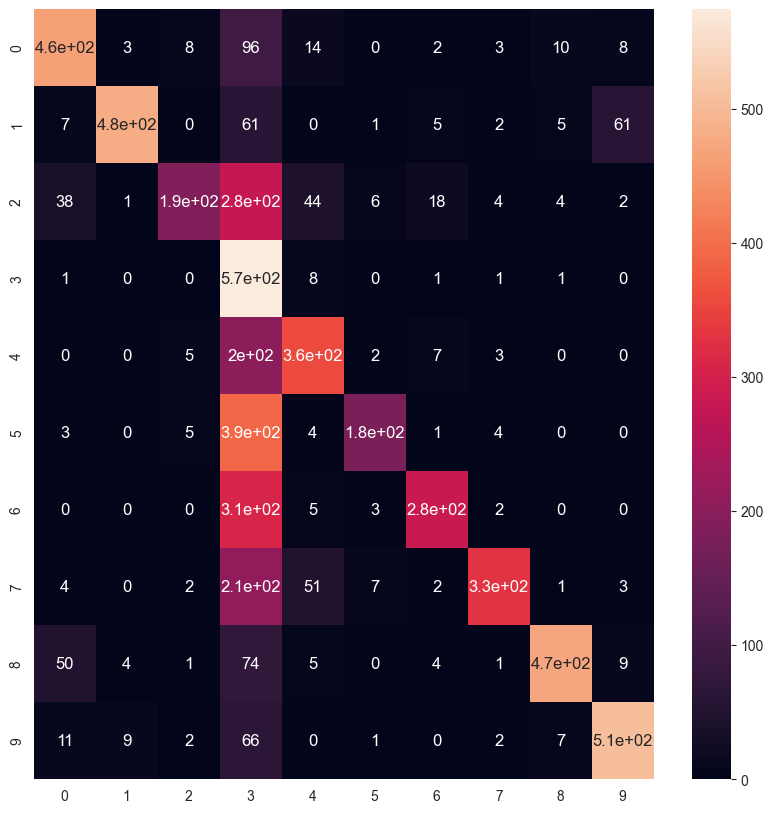

In [31]:
import seaborn as sns
Y_pred = model.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, range(10),range(10))
plt.figure(figsize = (10,10))

sns.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()